# Data Augmentation of the SPEED Dataset

Original dataset is from ESA's Kelvins pose estimation competition: https://gitlab.com/EuropeanSpaceAgency/speed-utils

This notebook helps outlines the data augmentation applied during preprocessing. The goal is to show how the various transformations are being applied to both the image and the target (ground truth data).

In [1]:
from matplotlib import pyplot as plt
from random import randint

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

from dataloader_utils import *

Let's set up the path to a local copy of the SPEED dataset, and instanciate the helper class.

In [2]:
dataset_root_dir = '../../speed'
annotations_root_dir = '../annotations'

# sample_transform = transforms.Compose([
#     transforms.RandomRotation((-30, 30))
# ])

## Preprocess Training Images

idx:  126
self.transform:  None
size:  (1920, 1200)


<Figure size 432x288 with 0 Axes>

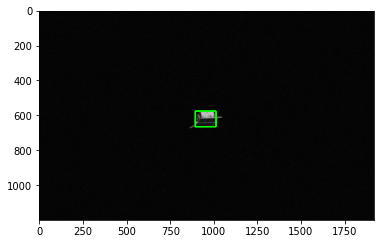

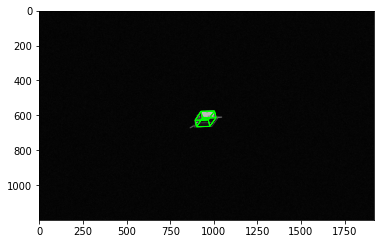

<Figure size 432x288 with 0 Axes>

In [3]:
idx = randint(0, 10)
idx = 126
print("idx: ", idx)
dataset = SpeedDataset(speed_root=dataset_root_dir, annotations_root=annotations_root_dir, transform=None)
img, _ = dataset[idx]
target_db = dataset.labels[idx]['bbox']
target_bb = dataset.labels[idx]['wireframe']
target_q = dataset.labels[idx]['q']
target_r = dataset.labels[idx]['r']
target = target_q, target_r, target_bb, target_db
sample1 = img, target_db
sample2 = img, target_bb
sample3 = img, target

plt.figure()
plt.imshow(img)
print("size: ", img.size)

visualize_tar(img, target_db)
plt.figure()
visualize_tar(img, target_bb)
plt.figure()
# visualize_tar2(img, target, bbox=True)

#### (a) Implement JointRescrop

This class should take a img, target pair and then apply a combination of square crop and rescaling to obtain an input size of 224x224 while capturing the entire satellite. The target can be either a 2d detection box or a 3d bounding box.

cropSize:  209
target_q:  [-0.477553, 0.658826, -0.531678, -0.234968]
target_r:  [-0.082061, 0.016849, 20.767683]
(256, 256)


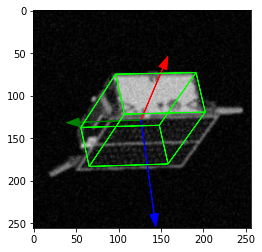

In [4]:
class JointRescrop(object):
    def __call__(self, img, target, size):
        target_q, target_r, target_bb, target_db = target
        sz = size[0]
        # Determine crop size that will still capture entire satellite
        x = [target_bb[i] for i in range(0, len(target_bb), 2)]
        y = [target_bb[i] for i in range(1, len(target_bb), 2)]
        xmin = min(x); xmax = max(x)
        ymin = min(y); ymax = max(y)
        fS = 1.75
        dx = xmax - xmin
        dy = ymax - ymin
        cropSize = int(fS * max(dx, dy))
        if cropSize > min(img.size):
            cropSize = min(img.size)
        print("cropSize: ", cropSize)
        
        # Crop Image
        xc = sum(x)/len(x)
        yc = sum(y)/len(y)
        top = yc - cropSize/2
        left = xc - cropSize/2
        img = tF.crop(img, top, left, cropSize, cropSize)
        
        # Crop translation of points
        xtarget = [cropSize/2 + (i - xc) for i in x]
        ytarget = [cropSize/2 + (i - yc) for i in y]
        target_bb = [None]*(len(xtarget)+len(ytarget))
        target_bb[::2] = xtarget
        target_bb[1::2] = ytarget
        
        # Rescale to input size
        norm = img.size[1]
        img = tF.resize(img, sz)
        target_bb = [sz * i / norm for i in target_bb]
        target = target_q, target_r, target_bb, target_db
        print("target_q: ", target_q)
        print("target_r: ", target_r)
        return (img, target)
        
        
I, T = sample3
size = (256, 256)
vectorScaleFactor = 4
img, target = JointRescrop()(I, T, size)
print(img.size)
sample1_in = img, target
visualize_tar2(img, target, size, vectorScaleFactor, bbox=True)


#### (b) Implement JointHFlip

This class should take a img, target pair and then apply a horizontal flip across the vertical axis. The target can be either a 2d detection box or a 3d bounding box.

In [5]:
class JointHFlip(object):
    def __call__(self, img, target):
        img = tF.hflip(img)
        x = [target[i] for i in range(0, len(target), 2)]
        y = [target[i] for i in range(1, len(target), 2)]
        length = img.size[0]
        xtarget = [length - i for i in x]
        ytarget = y
        target = [None]*(len(xtarget)+len(ytarget))
        target[::2] = xtarget
        target[1::2] = ytarget
        return (img, target)
        
I, T = sample1_in
# T = np.asarray(T)
# T = tF.ToTensor(T)
# print(np.round(T,2))
img, target = JointHFlip()(I, T)
visualize_tar(img, target)

TypeError: unsupported operand type(s) for -: 'int' and 'list'

#### (c) Implement JointRotate

This class should take a img, target pair and then apply a CCW rotation. Currently, this only works when the target is the 3d bounding box.

In [6]:
class JointRotate(object):
    def __call__(self, img, target, deg):
        ctr = img.size[0]/2
        img = tF.rotate(img, deg)
        rad = deg * np.pi/180
        R = np.array([[np.cos(rad), np.sin(rad)], [-np.sin(rad), np.cos(rad)]])
        xy_pairs = np.asarray([(target[i], target[i+1]) for i in range(0, len(target), 2)])
        xy_pairs = np.transpose(xy_pairs) - ctr
        xy_pairs = np.round(np.matmul(R, xy_pairs),2) + ctr
        xtarget = xy_pairs[0,:]
        ytarget = xy_pairs[1,:]
        target = [None]*(len(xtarget)+len(ytarget))
        target[::2] = xtarget
        target[1::2] = ytarget
        return (img, target)
        
I, T = sample1_in
degrees = 125
img, target = JointRotate()(I, T, degrees)
visualize_tar(img, target)

/home/andrew/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


TypeError: unsupported operand type(s) for -: 'list' and 'float'

#### (d) Implement JointFilter

This class should take a img, target pair and then filter the image based on brightness, contrast, intensity, hue, saturation. The target remains unchanged.
<br>
Brightness: fB
<br>
Contrast:   fC
<br>
Intensity:  fG
<br>
Hue:        fH
<br>
Saturaiton: fS

**Brightness** factor can be any non negative number. 0 gives a black image, 1 gives the original image while 2 increases the brightness by a factor of 2. 
<br>
**Contrast** factor can be any non negative number. 0 gives a solid gray image, 1 gives the original image while 2 increases the contrast by a factor of 2.
<br>
**Gamma** factor larger than 1 makes the shadows darker, while a factor less than 1 makes dark regions lighter.
<br>
**Hue** factor should be in [-0.5, 0.5]. 0.5 and -0.5 give complete reversal of hue channel in HSV space in positive and negative direction respectively. 0 means no shift. Therefore, both -0.5 and 0.5 will give an image with complementary colors while 0 gives the original image
<br>
**Saturation** factor of 0 will give a black and white image, 1 will give the original image while 2 will enhance the saturation by a factor of 2.
<br>

In [ ]:
class JointFilter(object):
    def __call__(self, img, target, fB=1, fC=1, fG=1, fH=0, fS=1):
        img = tF.adjust_brightness(img, fB)
        img = tF.adjust_contrast(img, fC)
        img = tF.adjust_gamma(img, fG)
        img = tF.adjust_hue(img, fH)
        img = tF.adjust_saturation(img, fS)
        return (img, target)
        
I, T = sample1_in
brightness_factor = 2
contrast_factor = 1.2
gamma_factor = 0.5
hue_factor = 0
saturation_factor = 1
img, target = JointFilter()(I, T, brightness_factor, contrast_factor, gamma_factor, hue_factor, saturation_factor)
visualize_tar(img, target)